In [22]:
from scipy import stats
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
import statistics
from tabulate import tabulate
from IPython.display import display, HTML
import plotly.graph_objects as go
import pandas_datareader as pdr
import datetime as dt
import plotly.express as px
import pandas_datareader as web
y_5 = 60
y_15 = 180
y_30 = 360

### CAPM - Capital Asset Pricing Model

It describes the relation between systematic risk and expected return. It is mostly used to price security and it shows that the expected return on a security is equal to the risk-free return plus a premium. That premium is related to the beta of the security/portfolio.

The CAPM formula is the following: ERi = Rf +βi (ERm −Rf)

where:
ERi = expected return of investment

Rf = risk-free rate

βi = beta of the investment

(ERm −Rf ) = market risk premium
​
Rf reflects the price of USA T-Bills, the data are provided by Fama/French 3 Factors.


### 1.3 - Beta, which is the coefficient of the explanatory variable

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


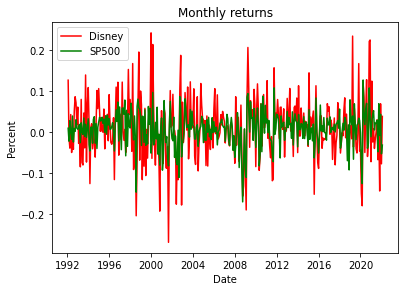

In [2]:
sp500 = yf.download('^GSPC','1992-01-01','2022-03-01', interval ='1mo')
disney = yf.download('DIS','1992-01-01','2022-03-01', interval ='1mo')
monthly_prices = pd.concat([sp500['Close'], disney['Close']], axis=1) 
monthly_prices.columns = ['^GSPC', 'DISNEY']
monthly_prices = monthly_prices.dropna()
monthly_returns = monthly_prices.pct_change(1)
clean_monthly_returns = monthly_returns.dropna(axis=0)

fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(clean_monthly_returns['DISNEY'], color='red', label='Disney')
ax1.plot(clean_monthly_returns['^GSPC'], color='green', label='SP500')
ax1.legend()
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Monthly returns")
plt.show()

In [3]:
def beta(val1, val2, period):
    X = val1.tail(period)
    y = val2.tail(period)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    return round(slope,4)

### 1.4 - Alpha, the constant term in regression/OLS

In [4]:
def alpha(val1, val2, period):
    X = val1.tail(period)
    y = val2.tail(period)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    return round(intercept,5)

In [5]:
def p_val(val1, val2, period):
    X = val1.tail(period) 
    y = val2.tail(period) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    return p_value

In [6]:
def rsquared(val1, val2, period):
    X = val1.tail(period)
    y = val2.tail(period)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
    return round((r_value**2),5)

### 1.1 - Average Excess returns, which is defined as (returns of a stock-risk-free returns)

In [7]:
riskfree = pd.read_csv('F-F_Research_Data_Factors_updated.csv')
riskfree.drop('SMB', axis=1, inplace=True)
riskfree.drop('HML', axis=1, inplace=True)
riskfree.rename(columns = {'Unnamed: 0' : 'Date'}, inplace = True)
 
list1 = riskfree['Date'].tolist()
list1 = [str(x) for x in list1]
string = '01'
list2 = list(map(lambda orig_string: orig_string + string, list1))
riskfree.drop('Date', axis = 1, inplace = True)
riskfree['Date'] = list2
riskfree['Date'] = pd.to_datetime(riskfree['Date'],format='%Y%m%d')
riskfree.set_index('Date', inplace=True, drop=True)
riskfree = riskfree/100
#data cleaning

In [8]:
def expected(period):
    slope = beta(period)
    rf = riskfree['RF'].tail(period).mean()
    rm = clean_monthly_returns['^GSPC'].tail(period).mean()
    ER_DISNEY = rf + (slope * (rm-rf))
    
    print('Disney expected returns is: {}%'.format(round(ER_DISNEY*12,3)*100)) #monthly val annualized and than *100 for %
    
    #return ER_DISNEY*1200 #monthly val annualized and than *100 for %

In [9]:
def excess(val2, period):
    rf = riskfree['RF'].tail(period).mean()
    excessofreturn = ((val2.tail(period).mean()-rf))*100
    return round(excessofreturn*(period))

### 1.2 - Sharp-ratio, which is Mean/Standard deviation of excess returns.

In [10]:
def sharp(val2, period):
    rf = riskfree['RF'].tail(period).mean()
    sharp_ratio = ((val2.tail(period).mean()-rf)/(val2.tail(period).std()))
    return round(sharp_ratio,4)

In [23]:
# x = benchmark monthly return
# y = stock monthly return

def fill(valx, valy):
    results = pd.DataFrame({ "TimeFrame": ['5 years', '15 years', '30 years'],
                "Beta": [beta(valx, valy, y_5),beta(valx, valy, y_15),beta(valx, valy, y_30)],
                "Alpha": [alpha(valx, valy, y_5), alpha(valx, valy, y_15), alpha(valx, valy, y_30)],
                "p-value": [p_val(valx, valy, y_5), p_val(valx, valy, y_15), p_val(valx, valy, y_30)],
                "R-sq": [rsquared(valx, valy, y_5), rsquared(valx, valy, y_15), rsquared(valx, valy, y_30)],
                "Sharpe-ratio": [sharp(valy, y_5), sharp(valy, y_15), sharp(valy, y_30)],
                "Avg Excess of return %": [excess(valx, y_5), excess(valx, y_15), excess(valx, y_30)],
            })
    results.set_index('TimeFrame', inplace=True)
    display(HTML(results.to_html(classes='table table-stripde')))
fill(clean_monthly_returns['^GSPC'], clean_monthly_returns['DISNEY'])

,Beta,Alpha,p-value,R-sq,Sharpe-ratio,Avg Excess of return %
TimeFrame,,,,,,
5 years,1.1746,-0.00517,1.315559e-08,0.42972,0.0895,63
15 years,1.1832,0.00204,2.638541e-33,0.55711,0.1427,120
30 years,1.1138,0.00122,2.735800e-42,0.40516,0.1047,201


## The Walt Disney (DIS) single Stock Analysis

### Beta

β measures how much risk is the stock/portfolio compared to holding our market benchmark, in this case the benchmark is the SP500.

How to understand β value:

- β = 0 means our stock has no correlation with our market benchmark
- β = 1 means our stock has perfect correlation with our market benchmark
- β < 1 = means our stock iss less volatile than our market benchmark
- β > 1 = means our stock iss more volatile than our market benchmark

In our case we can notice a value always greater than 1, it tells us that our choosen stock is more volatile than the market and therefore riskier.


### p-value Anlasysis

The p-value help us to understand if our Beta and alpha are statistically significant, we can say that:

- pval <= 0.05 is statistically significant, there is less than 5% probability of the null hypothesis (random results and no correlation)
- p-val > 0.05 is not statistically significant, it means strong evidence of null hypotesis

For our stock we have very low p-val, it means we can consider our beta and alpha statistically significant.


## R^2

"R-squared measures how closely each change in the price of an asset is correlated to a benchmark. Beta measures how large those price changes are in relation to a benchmark. Used together, R-squared and beta give investors a thorough picture of the performance of asset managers." (https://www.investopedia.com/ask/answers/012915/whats-relationship-between-r-squared-and-beta.asp)

There are two types of risk:

- Systematic risk: companies can't avoid it (es: market risk), it can be a crash of a specific sector, a blackswan or something else.
- Idiosyncratic risk: it is related with the company and reflects its action and performance

The systematic risk can't be avoided, but we can manage the idiosyncratic risk, the last one is reated with our R^2, the more stock we add to our portfolio, the more our idiosyncratic risk will be lower, thanks to diversification. An R^2 close to 1 tells us that we are almost equal to the risk of the market.

In this analysis, Disney has a R^2 with value between 0.4 and 0.55.

## Sharpe Ratio

The Sharpe ratio help us to understand the return of our stocks compared to its risk. It tells us how much return we have in excess of a risk-free per unit of volatility.
Usually a good Sharpe Ratio is around 1 but it must be compared with other portfolios or stock.

In this case we have very low sharpe rarios, it means that the risk associated to this stock is not worth the return generated over the observed period.

### 2 Multi-Stock Portfolio CAPM Analysis with SP500 as benchmark

In [12]:
tickers = ['DIS', 'CVX', 'WFC', 'BAC', 'IBM', 'PEP', 'JPM', 'GE', 'AXP', 'BRK-A']
start = dt.datetime(1992,1,1)
end = dt.datetime(2022,1,1)
portfolio = pdr.get_data_yahoo(tickers, start, end, interval='m')
portfolio.fillna(0, inplace=True)

In [13]:

benchmark_ret = clean_monthly_returns['^GSPC']
benchmark_ret = benchmark_ret[:-1]
portfolio_monthly_rets = portfolio['Adj Close'].pct_change(1, fill_method='ffill')
portfolio_monthly_rets.fillna(0, inplace=True) #print(df.loc[['2015-09-01']])

clean_portfolio = portfolio_monthly_rets.replace([np.inf, -np.inf], 0)
clean_portfolio = clean_portfolio.iloc[1: , :]
wts1 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1] #weights for portfolio balance
port_ret = (clean_portfolio * wts1).sum(axis = 1)


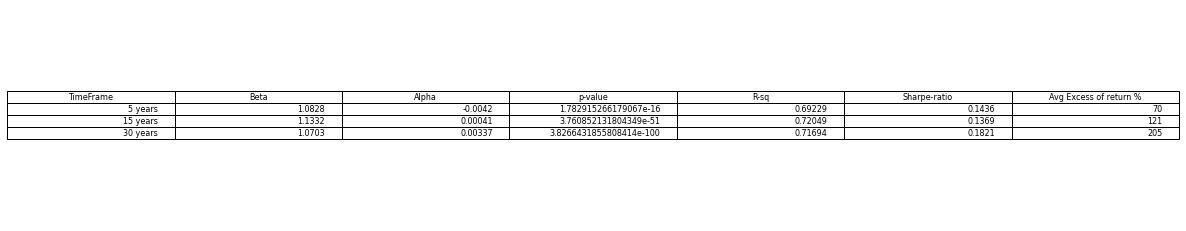

In [14]:
fill(benchmark_ret, port_ret)

## Risky portfolio CAPM Analysis

We have a risky portfolio which is composed by only stocks equally balanced as follow:
- DIS - The Walt Disney
- CVX - Chevron Corporation 
- WFC - Wells Fargo & Company
- BAC - Bank of America 
- IBM - International Business Machines Corporation
- PEP - Pepsi
- JPM - JPMorgan Chase & Co.
- GE -  General Electric Company
- AXP - American Express Company
- BRK-A - Berkshire Hathaway Inc.

As we can see from the table we have beta values which have followed our market benchmark (SP500) in the timeframe 5-30 years with more volatility in the timeframe of 15 years.

The p-value is very low and it tells us that our beta and alpha are statistically significant.

As explained before we can see a significantly increare in R^2 value thanks to the more diversification in adding more stock to the portfolio.

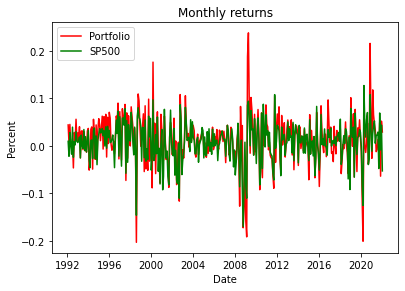

In [15]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(port_ret, color='red', label='Portfolio')
ax1.plot(benchmark_ret, color='green', label='SP500')
ax1.legend()
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title("Monthly returns")
plt.show()

### Portfolio vs SP500 growth of investment over 30 years

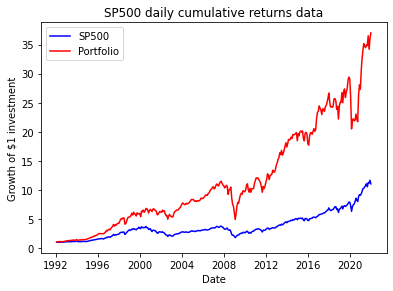

In [16]:
benchmark_cum_returns = (benchmark_ret + 1).cumprod()
portfolio_cum_returns = (port_ret + 1).cumprod()
fig = plt.figure()
ax2 = fig.add_axes([0.1,0.1,0.8,0.8])
ax2.plot(benchmark_cum_returns, color='blue',label='SP500')
ax2.plot(portfolio_cum_returns, color='red',label='Portfolio')
ax2.set_xlabel("Date")
ax2.set_ylabel("Growth of $1 investment")
ax2.set_title("SP500 daily cumulative returns data")
plt.legend(loc='best')
plt.show()

The plot above shows us the growth of an investment of 1$ in this portfolio compared to the SP500.

### Risky portfolio vs SP500 in 2008 crisis / performance

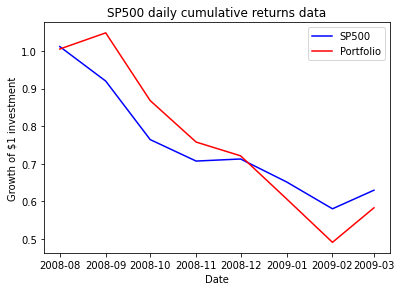

With an investment of 1000000$ in that portfolio just before August 2008 you would have had 582660$ in March 2009 which is -42% of the initial investment
With an investment of 1000000$ in sp500 just before August 2008 you would have had 629543$ in March 2009 which is -38% of the initial investment


In [17]:

benchmark_ret_crisis = benchmark_ret.loc['2008-8-1':'2009-3-1']
port_ret_crisis = port_ret.loc['2008-8-1':'2009-3-1']
portfolio_cum_returns = (port_ret_crisis + 1).cumprod()
benchmark_cum_returns = (benchmark_ret_crisis + 1).cumprod()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(benchmark_cum_returns, color='blue',label='SP500')
ax1.plot(portfolio_cum_returns, color='red',label='Portfolio')
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("SP500 daily cumulative returns data")
plt.legend(loc='best')
plt.show()
def crisis( portfolio, market):
    stockportfolio = portfolio[-1]
    marketportfolio = market[-1]
    investment = 1000000
    str1port = 'With an investment of 1000000$ in that portfolio just before August 2008 you would have had {}$ in March 2009'.format(round(stockportfolio*investment))
    str2port= ' which is {}% of the initial investment'.format(round((portfolio[-1]-portfolio[0])*100))
    str1market = 'With an investment of 1000000$ in sp500 just before August 2008 you would have had {}$ in March 2009'.format(round(marketportfolio*investment))
    str2market = ' which is {}% of the initial investment'.format(round((market[-1]-market[0])*100))
    print(str1port + str2port)
    print(str1market+str2market)
crisis(portfolio_cum_returns, benchmark_cum_returns)



### Risk-averse portfolio vs market in 2008 crisis / performance

In [18]:
extracted = riskfree['RF']
safe_portfolio = clean_portfolio.join(extracted)
safe_portfolio
wts2 = [0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.4]
safe_port_ret = (safe_portfolio * wts2).sum(axis = 1)

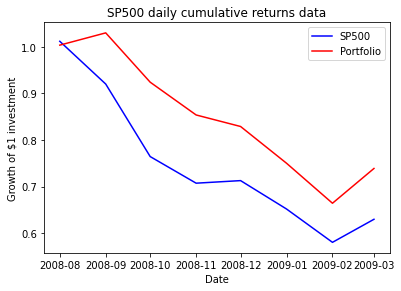

With an investment of 1000000$ in that portfolio just before August 2008 you would have had 738811$ in March 2009 which is -27% of the initial investment
With an investment of 1000000$ in sp500 just before August 2008 you would have had 629543$ in March 2009 which is -38% of the initial investment


In [21]:
benchmark_ret_crisis = benchmark_ret.loc['2008-8-1':'2009-3-1']
safe_port_ret_crisis = safe_port_ret.loc['2008-8-1':'2009-3-1']
safe_portfolio_cum_returns = (safe_port_ret_crisis + 1).cumprod()
benchmark_cum_returns = (benchmark_ret_crisis + 1).cumprod()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(benchmark_cum_returns, color='blue',label='SP500')
ax1.plot(safe_portfolio_cum_returns, color='red',label='Portfolio')
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title("SP500 daily cumulative returns data")
plt.legend(loc='best')
plt.show()

crisis(safe_portfolio_cum_returns, benchmark_cum_returns)

In the plot above we can see the performance of another portfolio in the period of the 2008 crisis, it is weightes ad folow:

- 40% risk-free USA T-bill 
- 60% stocks of the previous portfolio

As we can see with this portfolio in 2008 crisis we would have had a -27% compared to -42% of a only stocks portfolio. 

### 2 Multi-Stock Portfolio CAPM Analysis with Fama-French as benchmark

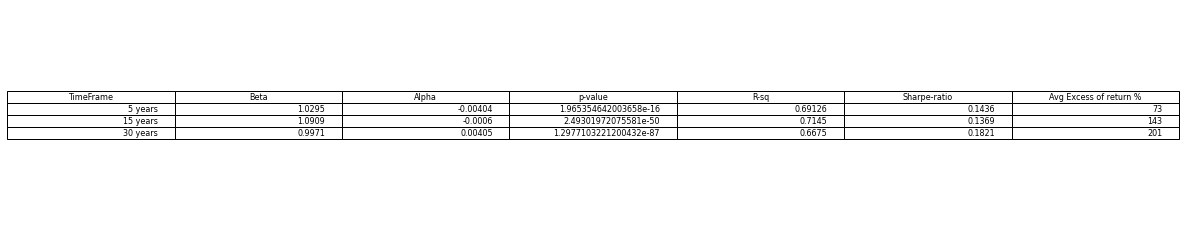

In [20]:
fill(riskfree['Mkt-RF'], port_ret)

As we can see from the table we have beta valueS which have followed almost perfectly our market benchmark (Fama-French), it means that our portfolio would have had almost the same volatility of the market.

It shows us that at least with this portfolio we have less volatility wit Fama-French Rm-Rf compared to use SP500 as benchmark.

The p-value is very low and it tells us that our beta and alpha are statistically significant.
